In [1]:
import numpy as np

def debug_signal_handler(signal, frame):
    import pdb
    pdb.set_trace()
import signal
signal.signal(signal.SIGINT, debug_signal_handler)

seq_size = 1000

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#https://www.biostars.org/p/710/
from itertools import groupby
def fasta_iter(fasta_name):
    """
        given a fasta file, yield tuples of (header, sequence)
    """
    fh = open(fasta_name) # file handle
    # ditch the boolean (x[0]) and just keep the header or sequence since they alternate
    fa_iter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in fa_iter:
        header = header.next()[1:].strip() # drop the ">" from the header
        seq = "".join(s.strip() for s in fa_iter.next()) # join all sequence lines to one
        yield header, seq

# take input sequence name and return the onehot encoding
def fasta_to_onehot(input_name):
    fasta_sequences = []

    fasta = fasta_iter(input_name)

    onehot = []
    for header, seq in fasta:   
        fasta_sequences.append(seq)
        onehot_seq = one_hot_encode_along_channel_axis(seq)
        onehot.append(onehot_seq)
        
    return onehot, fasta_sequences

# could be optimized, don't need onehot
'''
def get_snp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    hyp_scores = hyp_scpres[:100]
    off = int((seq_size-1)/2)
    snp_hyp = hyp_scores[:, off]

    #print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    #print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:5]=\n", snp_onehot[:5])

    snp_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        snp_scores.append(np.sum(snp_score))
    print("snp_scores done ", len(snp_scores))
    print(snp_scores[:5])
    return snp_scores
'''
def get_imp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    onehot, seqs = fasta_to_onehot(seq_file)
    #hyp_scores = hyp_scores[:10]
    #onehot     = onehot[:10]
    #print("onehot done ", len(onehot))
    #print("onehot[:5]=\n", onehot[:5])

    imp_scores = []
    for i in range(len(hyp_scores)):
        contrib_score = hyp_scores[i] * onehot[i]
        #imp_scores.append(np.sum(contrib_score, axis=-1))
        imp_scores.append(contrib_score)

    #print("imp_scores shape=", imp_scores[0].shape, len(imp_scores))
    #print(imp_scores[:2][:5])
    return imp_scores, seqs

def get_snp_hyp_score_diff(score_file, seq_file):
    hyp_scores = np.load(score_file)
    off = int((seq_size)/2)
    snp_hyp = hyp_scores[:, off]

    print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:2]=\n", snp_onehot[:2][:5])

    diff_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        diff      = snp_hyp[i] - snp_score
        max_diff  = np.max(np.abs(diff), axis=-1)
        #print(diff.shape, max_diff.shape)

        diff_scores.append(max_diff)
    print("diff_scores done ", len(diff_scores))
    #print(diff_scores[:5])
    return diff_scores

def max_sub_array_sum(a, size): 
      
    max_so_far = 0
    max_ending_here = 0
      
    for i in range(0, size): 
        max_ending_here = max_ending_here + a[i] 
        if max_ending_here < 0: 
            max_ending_here = 0
          
        # Do not compare for all elements. Compare only    
        # when  max_ending_here > 0 
        elif (max_so_far < max_ending_here): 
            max_so_far = max_ending_here 
              
    return max_so_far 

def center_window_sum(a, snp, win):
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = np.sum(a[snp][start:end])
    return score

def calc_bis_score(a, win):
    #return max_sub_array_sum(a, size)
    win_sums = []
    for snp in range(len(a)):
        win_sum = center_window_sum(a, snp, win)
        win_sums.append(win_sum)
    return win_sums

# snp_diffs[i] i= 0,1,2 are the score differences for 3 alleles
# for each allele, it stored differences for each SNP
# for each SNP, it stored differences for 1k bp surrounding the SNP, of shape (1000)
def get_diff_scores(score_prefix, seq_prefix):
    snp_alleles = {}
    snp_diffs   = {}
    snp_orig, _ = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
    print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))
    for i in range(3):
        snp_allele, _  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff
        print("snp_diff " + str(i+1) + " shape=", snp_diff[0].shape) #, "\n" , snp_diff[:2][:5])
    return snp_diffs
        
def get_bis_scores(snp_diffs):
    bis_scores  = {}
    for i in range(3):
        bis_scores[i] = calc_bis_score(snp_diffs[i], 31)
    # elementwise max among 3 lists
    max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
    return max_bis_score


from numpy import genfromtxt
import math

def get_snp_pvals(fname):
    snp_pvals = []
    lines     = []
    with open(fname) as in_fh:
        header = next(in_fh)
        line_num = 0
        for line in in_fh:
            fields = line.split('\t')
            snp_chrom = fields[0]
            snp_pos   = int(fields[1])
            pval  = float(fields[9])
            lines.append(line)
            snp_pvals.append(-math.log(pval, 10))
            line_num += 1
    return snp_pvals, lines

('snp_orig shape=', (1000, 4), 20000)
('snp_diff 1 shape=', (1000, 4))
('snp_diff 2 shape=', (1000, 4))
('snp_diff 3 shape=', (1000, 4))


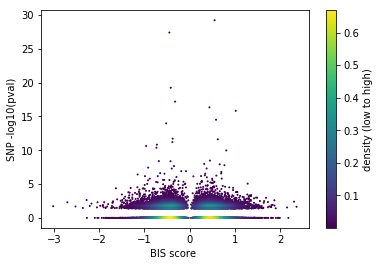

<Figure size 432x288 with 0 Axes>

In [2]:
#diff_scores = get_snp_hyp_score_diff("scores/hyp_scores_task_0.npy")
snp_diffs  = get_diff_scores("scores/hyp_scores_task_0.npy", "scores/interpret.fa")
bis_scores = get_bis_scores(snp_diffs)



#snp_dir = "/Users/kat/kundajelab/tmp/bQTL/bQTL_all_SNPs/"
snp_dir  = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/"
#snp_file = "STAT1_10k.txt"
snp_file = "STAT1_20k.txt"

snp_pvals, lines = get_snp_pvals(snp_dir + snp_file)

#print(len(snp_pvals))
#print(len(bis_scores))

#%matplotlib inline
tf = 'STAT1'

%matplotlib inline
import matplotlib as mpl
#mpl.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

#fig=plt.figure(figsize=(10, 8), dpi= 100)

x=bis_scores[:]
y=snp_pvals[:]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, 1, c=z, alpha=1, marker='o', label=".")
plt.xlabel("BIS score ")
plt.ylabel("SNP -log10(pval)")
plt.colorbar(label='density (low to high)')

#plt.legend(loc=2)
plt.show()    
plt.savefig("deeplift_score_vs_pval.png")    

# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

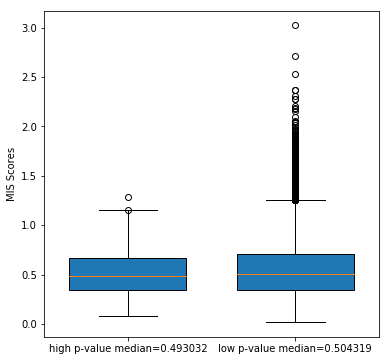

In [3]:
fig = plt.figure(1, figsize=(6, 6))

limit = 100
hi = [abs(i) for i in x[:limit]]
lo = [abs(i) for i in x[limit:]]
data_to_plot = [hi, lo]
median_hi = np.median(hi)
median_lo = np.median(lo)
xlabels = ["high p-value median=%f" % median_hi , "low p-value median=%f" % median_lo]

bp = plt.boxplot(data_to_plot, labels=xlabels, widths=0.7, patch_artist=True)
plt.ylabel("MIS Scores")
plt.show()


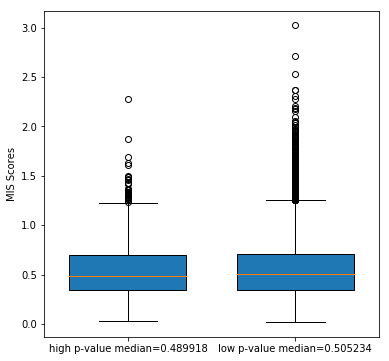

In [4]:
fig = plt.figure(1, figsize=(6, 6))

limit = 1000
hi = [abs(i) for i in x[:limit]]
lo = [abs(i) for i in x[limit:]]
data_to_plot = [hi, lo]
median_hi = np.median(hi)
median_lo = np.median(lo)
xlabels = ["high p-value median=%f" % median_hi , "low p-value median=%f" % median_lo]

bp = plt.boxplot(data_to_plot, labels=xlabels, widths=0.7, patch_artist=True)
plt.ylabel("MIS Scores")
plt.show()


Using cuDNN version 7001 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:08:00.0)


-----
scores/interpret.fa0
(20000, 1000, 4)
[[-0.08568998  0.01899648  0.02728072  0.19311121]
 [ 0.01239415  0.15360554 -0.03503127 -0.13927259]
 [ 0.00393701 -0.0036127   0.00436408 -0.01727655]
 [ 0.00087636 -0.01378504 -0.034575    0.07763717]
 [ 0.04577125  0.10110281  0.01356219 -0.06505828]
 [ 0.10511516  0.00223843  0.0685446  -0.01802029]
 [ 0.03970269 -0.0771125  -0.05857835  0.09584243]
 [ 0.10095206 -0.03666532  0.00243423 -0.07386352]
 [ 0.05437503  0.06419315 -0.00769456  0.00426667]
 [ 0.12075836  0.06760594 -0.02501351 -0.07798214]]
-----
0 chr6:26660655 G->C score=0.55216 loss
1 chr7:100230864 G->C score=-0.44910 loss
('CACCGTGACGTTGCC[G]ATGGCGCTGTAGGGG', 'importance score for original sequence')


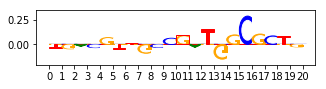

('CACCGTGACGTTGCC[C]ATGGCGCTGTAGGGG', 'importance score for mutated sequence ')


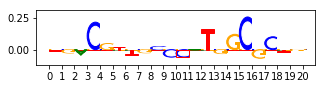

Mutation Impact Score 


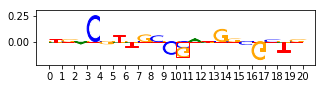

2 chr7:12727826 G->C score=-0.41904 gain
3 chr7:303680 A->G score=-0.32107 gain
4 chr1:145209819 C->T score=0.43823 gain
5 chr19:2598511 T->C score=1.01973 gain
6 chr19:2598515 T->C score=0.58440 gain
7 chr14:23026213 G->C score=-0.51978 loss
8 chr14:24476433 C->G score=-0.37654 gain
9 chr4:84145537 A->T score=0.62228 gain
10 chr1:144521492 G->T score=-0.38193 loss
('ACCTCCACTCGCGCC[G]GGAGCTGAGCGGCAG', 'importance score for original sequence')


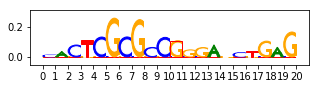

('ACCTCCACTCGCGCC[T]GGAGCTGAGCGGCAG', 'importance score for mutated sequence ')


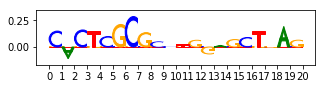

Mutation Impact Score 


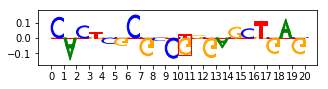

11 chr4:84145532 G->A score=-0.72563 gain
12 chr6:26305407 G->C score=-0.96264 gain
13 chr16:21513372 T->C score=-0.73504 gain
14 chr16:15068908 C->G score=0.81143 gain
15 chr1:145254652 G->A score=0.44882 gain
16 chr2:114148097 C->G score=-0.68259 loss
17 chr14:106790361 G->A score=-0.42349 gain
18 chr1:948692 G->A score=0.32226 loss
('CTGTCCGGAGTCCCC[G]CCACTTTTGCTTTTC', 'importance score for original sequence')


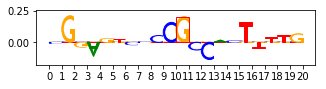

('CTGTCCGGAGTCCCC[A]CCACTTTTGCTTTTC', 'importance score for mutated sequence ')


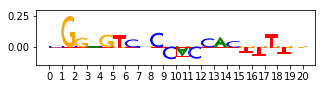

Mutation Impact Score 


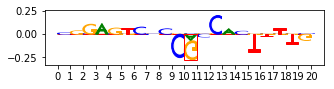

19 chr7:102119410 T->G score=0.66568 gain
20 chr6:133119778 G->A score=0.77033 loss
21 chr1:144932151 G->T score=-0.34649 loss
('CGGCTTCGCGTCTGC[G]GCCTCCACAAGGCTC', 'importance score for original sequence')


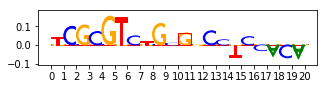

('CGGCTTCGCGTCTGC[T]GCCTCCACAAGGCTC', 'importance score for mutated sequence ')


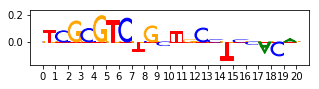

Mutation Impact Score 


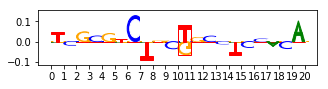

22 chr1:120611496 C->A score=-0.91830 gain
23 chr3:88108540 C->T score=0.37524 loss
('CCATTGTGGAGTCCC[C]GCTGGGCCCTGTGGG', 'importance score for original sequence')


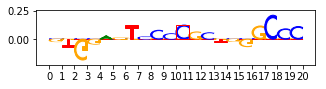

('CCATTGTGGAGTCCC[T]GCTGGGCCCTGTGGG', 'importance score for mutated sequence ')


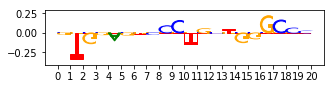

Mutation Impact Score 


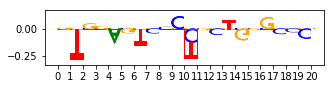

24 chr9:126959681 T->G score=-0.39686 loss
('CACCTGCCTGCCCAG[T]TGGACCCTCTCAGAG', 'importance score for original sequence')


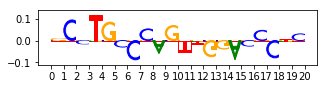

('CACCTGCCTGCCCAG[G]TGGACCCTCTCAGAG', 'importance score for mutated sequence ')


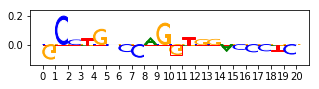

Mutation Impact Score 


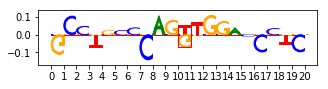

25 chr4:84145486 T->C score=-0.18625 gain
26 chr2:114361543 T->A score=-0.08140 gain
27 chr17:41437814 T->C score=0.70149 loss
28 chr14:107120205 G->C score=-0.65266 loss
29 chr4:154006453 T->A score=0.69825 loss
30 chr1:144932401 G->C score=0.34402 loss
('GAGGCTCCTCCTCGC[G]GGGAGGAGAAAGACG', 'importance score for original sequence')


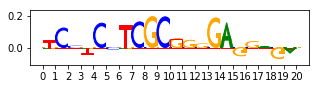

('GAGGCTCCTCCTCGC[C]GGGAGGAGAAAGACG', 'importance score for mutated sequence ')


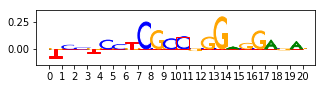

Mutation Impact Score 


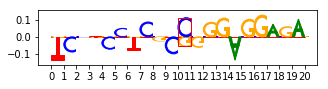

31 chr7:56174351 C->G score=-0.55833 loss
32 chr4:142043415 C->G score=-1.15154 gain
33 chr1:17199059 C->G score=0.33605 loss
('ACAGAAGAAGGGAGA[C]AAAGCTCCCTCCTGT', 'importance score for original sequence')


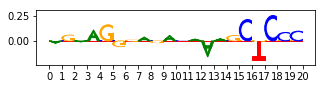

('ACAGAAGAAGGGAGA[G]AAAGCTCCCTCCTGT', 'importance score for mutated sequence ')


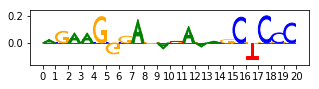

Mutation Impact Score 


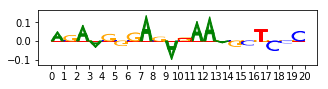

34 chr1:11046182 G->A score=0.59132 loss
35 chr1:144534083 C->T score=0.25318 loss
('tgaagttggtgtttt[c]cgggggcggtttttc', 'importance score for original sequence')


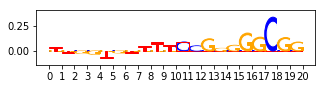

('TGAAGTTGGTGTTTT[T]CGGGGGCGGTTTTTC', 'importance score for mutated sequence ')


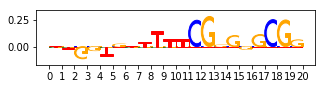

Mutation Impact Score 


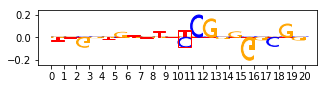

36 chr1:144568672 A->G score=-0.70687 loss
37 chr12:8715082 G->T score=-0.98973 gain
38 chr6:117001824 C->A score=0.08282 loss
('tcaaaaaaaaccccc[c]aaaaacagaaaaaca', 'importance score for original sequence')


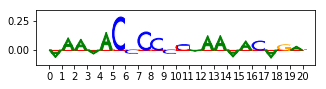

('TCAAAAAAAACCCCC[A]AAAAACAGAAAAACA', 'importance score for mutated sequence ')


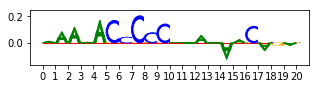

Mutation Impact Score 


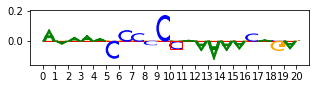

39 chr3:46469230 G->T score=-0.29257 gain
40 chr9:70646472 G->A score=0.38055 gain
41 chr12:104278375 C->G score=0.70982 loss
42 chr21:46976111 C->T score=-0.88316 loss
43 chr11:33060769 T->C score=0.49710 loss
('GCGGCGCGCGTTCCG[T]CTTTCCGTATGGAAA', 'importance score for original sequence')


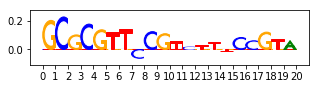

('GCGGCGCGCGTTCCG[C]CTTTCCGTATGGAAA', 'importance score for mutated sequence ')


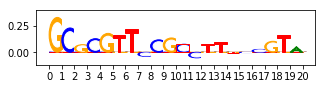

Mutation Impact Score 


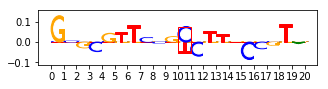

44 chr1:150459715 T->C score=-0.58961 loss
45 chr5:150460083 G->T score=-0.56410 loss
46 chr1:148556066 G->A score=-0.44761 loss
('GTTGAGACAGCGGCG[G]TATCGGGAGGGGTAG', 'importance score for original sequence')


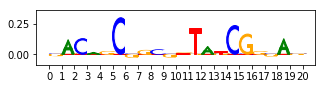

('GTTGAGACAGCGGCG[A]TATCGGGAGGGGTAG', 'importance score for mutated sequence ')


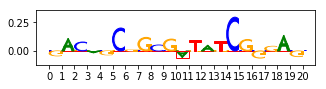

Mutation Impact Score 


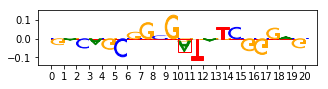

47 chr9:37529344 A->G score=0.50475 loss
48 chr17:1388656 G->T score=-0.32909 loss
('CCCAGATTTCTGGCC[G]GGGGCCTGCCCCTCC', 'importance score for original sequence')


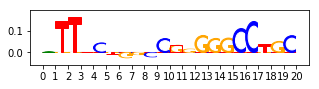

('CCCAGATTTCTGGCC[T]GGGGCCTGCCCCTCC', 'importance score for mutated sequence ')


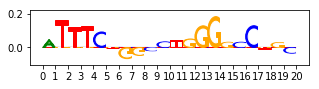

Mutation Impact Score 


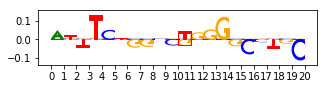

49 chr1:160854620 T->C score=-0.92027 gain
50 chr11:18433780 A->G score=-0.33269 loss
('TCCAGGGCAGAAAAG[A]CGCCCCATGCCCGCG', 'importance score for original sequence')


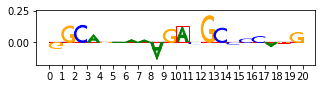

('TCCAGGGCAGAAAAG[G]CGCCCCATGCCCGCG', 'importance score for mutated sequence ')


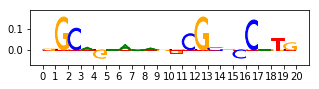

Mutation Impact Score 


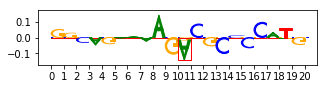

51 chr17:3817178 C->T score=0.27050 gain
52 chr11:33061663 C->T score=-0.24730 loss
('CAGAGCCCCTTTTTT[C]TTTTGCCGAAAGACC', 'importance score for original sequence')


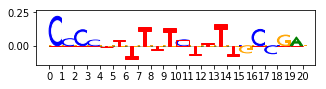

('CAGAGCCCCTTTTTT[T]TTTTGCCGAAAGACC', 'importance score for mutated sequence ')


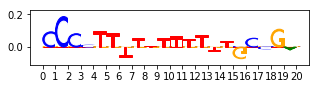

Mutation Impact Score 


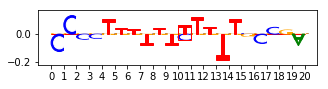

53 chr2:55845109 T->C score=0.39869 loss
('ACGTTCCTAGGAACT[T]AGCTCTGAGGAAAAA', 'importance score for original sequence')


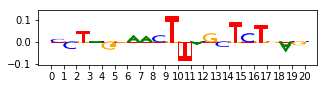

('ACGTTCCTAGGAACT[C]AGCTCTGAGGAAAAA', 'importance score for mutated sequence ')


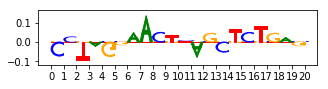

Mutation Impact Score 


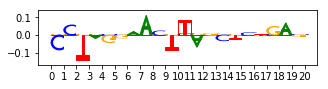

54 chr18:48677705 G->C score=-0.13706 loss
('AGAAGGCAGGCACTG[G]AGAAGGCAGGCActg', 'importance score for original sequence')


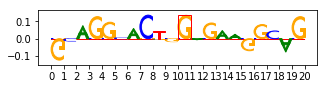

('AGAAGGCAGGCACTG[C]AGAAGGCAGGCACTG', 'importance score for mutated sequence ')


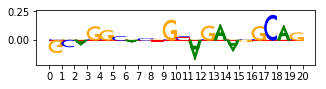

Mutation Impact Score 


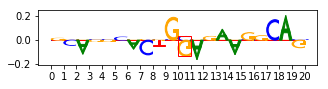

55 chr2:86422816 T->G score=0.54705 loss
56 chr7:8161201 T->C score=0.27108 gain
57 chr11:842775 G->A score=-0.35568 loss
('AGACCGCACACCCCC[G]CCCACCGTCTTGGTG', 'importance score for original sequence')


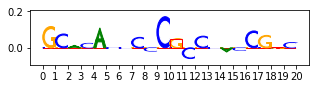

('AGACCGCACACCCCC[A]CCCACCGTCTTGGTG', 'importance score for mutated sequence ')


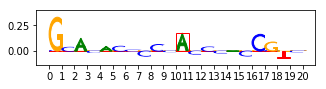

Mutation Impact Score 


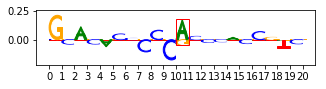

58 chr1:111740345 C->G score=0.54377 gain
59 chr1:179335264 A->C score=0.25703 loss
('GCCTGTGGGGAAGGT[A]TGGTCCCCAGCCGAG', 'importance score for original sequence')


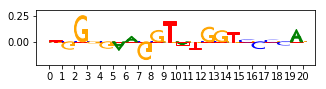

('GCCTGTGGGGAAGGT[C]TGGTCCCCAGCCGAG', 'importance score for mutated sequence ')


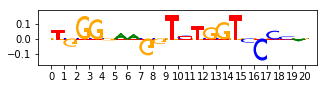

Mutation Impact Score 


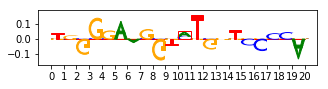

60 chr5:64064590 G->A score=-0.74127 loss
61 chr18:3248264 C->T score=-0.70971 loss
62 chr17:21235772 G->A score=0.45783 gain
63 chr22:43165948 C->T score=0.48896 loss
('ggTGGGTTCTCAGCC[C]GGCTGGGCGGCACCC', 'importance score for original sequence')


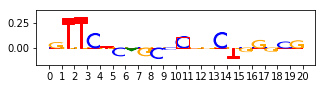

('GGTGGGTTCTCAGCC[T]GGCTGGGCGGCACCC', 'importance score for mutated sequence ')


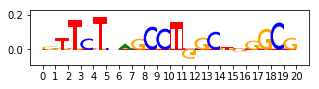

Mutation Impact Score 


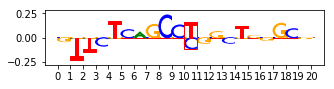

64 chr1:210001173 C->T score=0.50696 loss
65 chr19:1103414 A->G score=0.51026 loss
66 chr15:52404216 G->A score=-0.09717 gain
67 chr1:144917841 T->C score=1.28354 loss
68 chr2:131850387 T->A score=0.22950 loss
('CGCCAAGCaaaaaaa[t]aaaaataaaaattat', 'importance score for original sequence')


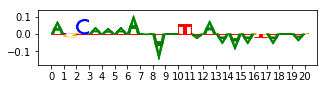

('CGCCAAGCAAAAAAA[A]AAAAATAAAAATTAT', 'importance score for mutated sequence ')


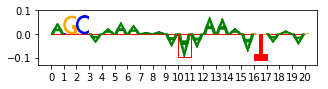

Mutation Impact Score 


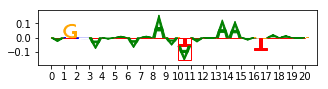

69 chr16:15069303 G->C score=0.16977 loss
('GGCTGGGCGGGGTTC[G]GTGGGGGCCGCGACG', 'importance score for original sequence')


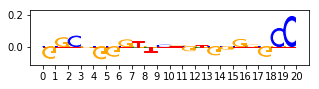

('GGCTGGGCGGGGTTC[C]GTGGGGGCCGCGACG', 'importance score for mutated sequence ')


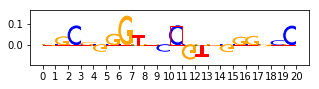

Mutation Impact Score 


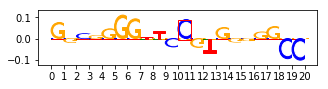

70 chr17:33571546 G->A score=-0.93902 gain
71 chr19:52408216 G->A score=-0.36212 loss
('ATGCTTCCTTTCCTG[G]CCCTTAAACCCCGGC', 'importance score for original sequence')


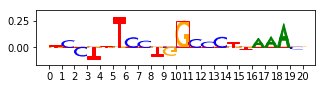

('ATGCTTCCTTTCCTG[A]CCCTTAAACCCCGGC', 'importance score for mutated sequence ')


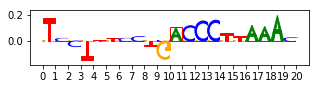

Mutation Impact Score 


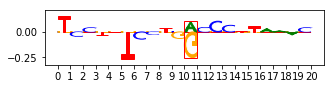

72 chr2:132250074 C->A score=-0.10880 gain
73 chr8:73067682 T->C score=-0.58712 loss
74 chr22:45683837 T->C score=-0.25084 loss
('gggcgtgagctgcca[t]gcctggcccatcttg', 'importance score for original sequence')


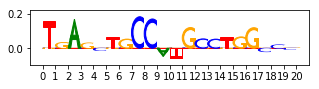

('GGGCGTGAGCTGCCA[C]GCCTGGCCCATCTTG', 'importance score for mutated sequence ')


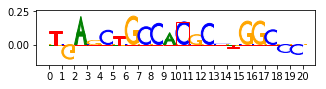

Mutation Impact Score 


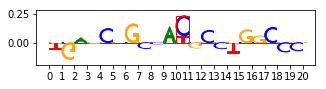

75 chr1:209929044 C->G score=-0.99553 loss
76 chr19:52408217 C->A score=0.39906 loss
('TGCTTCCTTTCCTGG[C]CCTTAAACCCCGGCA', 'importance score for original sequence')


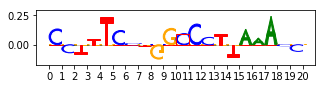

('TGCTTCCTTTCCTGG[A]CCTTAAACCCCGGCA', 'importance score for mutated sequence ')


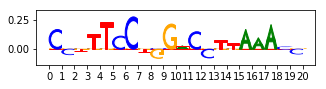

Mutation Impact Score 


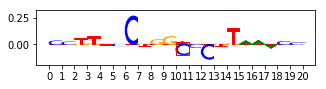

77 chr1:17231724 A->G score=-0.15034 gain
78 chr14:76660887 T->C score=-0.40824 loss
('ATGCATGCACCCTTT[T]CAACTGTGCAAGTTA', 'importance score for original sequence')


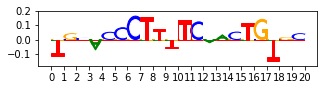

('ATGCATGCACCCTTT[C]CAACTGTGCAAGTTA', 'importance score for mutated sequence ')


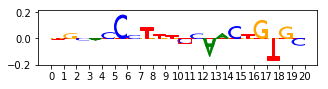

Mutation Impact Score 


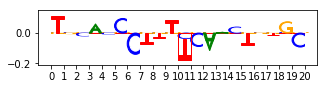

79 chr21:10470229 A->G score=0.35554 gain
80 chr8:110064864 A->G score=0.39239 loss
('tacacaaaagaaaaa[a]taaaagctaggaaaa', 'importance score for original sequence')


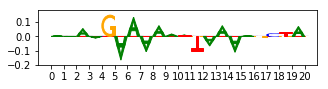

('TACACAAAAGAAAAA[G]TAAAAGCTAGGAAAA', 'importance score for mutated sequence ')


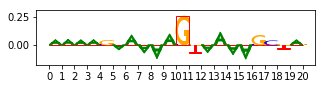

Mutation Impact Score 


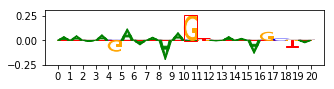

81 chr5:53502621 T->A score=0.73212 gain
82 chr7:31727926 G->A score=-0.54304 loss
83 chr12:8608502 T->A score=0.59108 loss
84 chr10:45875793 T->C score=-0.45798 gain
85 chr9:141045195 A->G score=0.53868 loss
86 chr2:215861559 G->T score=0.51625 loss
87 chr15:70780286 A->G score=0.78520 loss
88 chr9:126959586 C->T score=-0.41789 loss
('gaggtacaaatatgg[c]ccctgaggttccacc', 'importance score for original sequence')


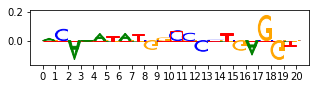

('GAGGTACAAATATGG[T]CCCTGAGGTTCCACC', 'importance score for mutated sequence ')


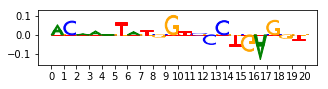

Mutation Impact Score 


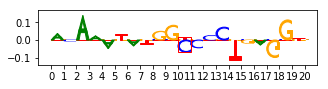

89 chr6:2903584 G->A score=-0.37551 loss
('TTATACCGCAGGGTC[G]GGCGCCTCCCACGCT', 'importance score for original sequence')


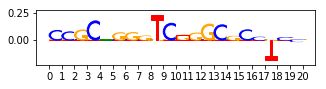

('TTATACCGCAGGGTC[A]GGCGCCTCCCACGCT', 'importance score for mutated sequence ')


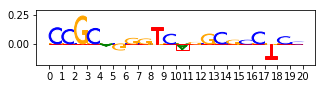

Mutation Impact Score 


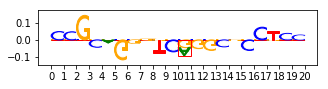

90 chr14:68069476 C->A score=0.29983 loss
('gatattttcttttca[c]aataattgtttcaaa', 'importance score for original sequence')


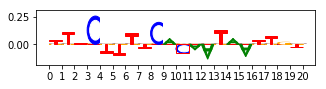

('GATATTTTCTTTTCA[A]AATAATTGTTTCAAA', 'importance score for mutated sequence ')


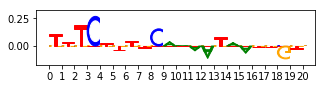

Mutation Impact Score 


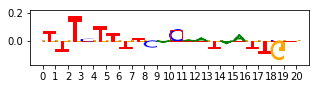

91 chr1:714427 G->A score=-0.41711 loss
('GCTCCTCAATGGCCA[G]CGCCAGCTGCAGCCC', 'importance score for original sequence')


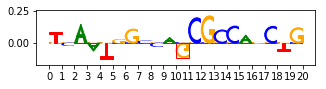

('GCTCCTCAATGGCCA[A]CGCCAGCTGCAGCCC', 'importance score for mutated sequence ')


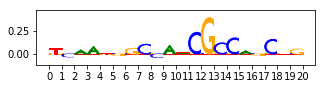

Mutation Impact Score 


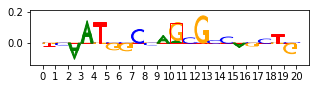

92 chr12:9911586 C->T score=-1.15780 gain
93 chr17:43662679 A->C score=0.24327 loss
('GGGCTGGGCGCAGCG[A]GGCGCGGCTGGACTC', 'importance score for original sequence')


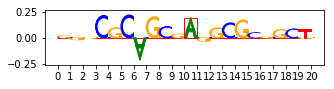

('GGGCTGGGCGCAGCG[C]GGCGCGGCTGGACTC', 'importance score for mutated sequence ')


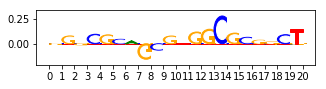

Mutation Impact Score 


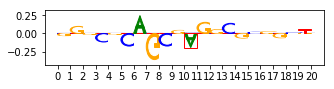

94 chr12:11700290 G->A score=0.87696 loss
95 chr17:37061502 C->T score=0.54037 loss
96 chr14:107150591 T->C score=-0.08248 loss
('tactaatttaaatgc[t]caacagtttatgagt', 'importance score for original sequence')


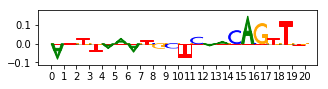

('TACTAATTTAAATGC[C]CAACAGTTTATGAGT', 'importance score for mutated sequence ')


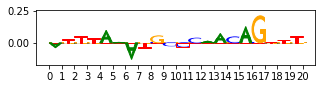

Mutation Impact Score 


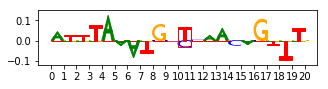

97 chr14:107150595 C->T score=-0.55017 loss
98 chr7:47189260 A->T score=-0.54658 loss
99 chr14:100531416 T->C score=0.50288 loss
('max_mis_score=\n', [0.55215997, -0.44910476, -0.41904122, -0.32107052, 0.43823472])


In [5]:
from modisco.visualization import viz_sequence
np.set_printoptions(suppress=True)

score_prefix = "scores/hyp_scores_task_0.npy"
seq_prefix   = "scores/interpret.fa"
snp_alleles = {}
snp_diffs   = {}
seqs        = {}
snp_orig, orig_seqs = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
score_file = score_prefix + "0"
seq_file   = seq_prefix + "0"

hyp_scores = np.load(score_file)
onehot, _  = fasta_to_onehot(seq_file)

print("-----")
print(seq_file)
print(hyp_scores.shape)
print(hyp_scores[2][495:505])
print("-----")
#hyp_scores = hyp_scores[:10]
#onehot     = onehot[:10]
#print("onehot done ", len(onehot))
#print("onehot[:5]=\n", onehot[:5])

imp_scores = []
for i in range(len(hyp_scores)):
    contrib_score = hyp_scores[i] * onehot[i]
    imp_scores.append(np.sum(contrib_score, axis=-1))

'''
highlight={'r':[(10,11)]}
for start_pos, end_pos in highlight['r']:
    print(highlight['r'])
    print(start_pos, end_pos)
'''

allele_idx = [0,2,0] # A->G(1), C->A(0), C->T(2)

snp_desc   = ["SNP chr4:176935913 C->A", "SNP chr12:16789835 C->T", "SNP chr12:8608502 T->A"]

def seqs_str(seqs, snp):
    return seqs[snp][485:500] + '[' + seqs[snp][500:501] + ']' + seqs[snp][501:516]

thresh = 0.5

#print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))

for i in range(3): # each i is an allele
    snp_alleles[i], seqs[i]  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)

for snp in range(100):

    #print(fasta_sequences[snp][495:505])
    #print(snp_orig[snp][495:505])
    line = lines[snp]
    fields = line.split('\t')
    alt_depth = int(fields[3])
    ref_depth = int(fields[4])
    print("%d %s:%s %s->%s score=%.5f %s" % (snp, fields[0], fields[1], fields[6], fields[5], x[snp], 
          "gain" if alt_depth > ref_depth else "loss"))

    if not (abs(x[snp]) > thresh or alt_depth > ref_depth):
        print(seqs_str(orig_seqs, snp), "importance score for original sequence")
        viz_sequence.plot_weights(snp_orig[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

    bis_scores  = {}

    for i in range(3): # each i is an allele
        snp_allele = snp_alleles[i]
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        #snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff

        if abs(x[snp]) > thresh or alt_depth > ref_depth:
            continue
        if fields[5] == seqs[i][snp][500]:
        #if i == allele_idx[snp]:

            print(seqs_str(seqs[i], snp), "importance score for mutated sequence ")
            #print(snp_allele[snp][495:505])
            viz_sequence.plot_weights(snp_allele[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

            print("Mutation Impact Score ")
            #print(snp_diff[snp][495:505])
            viz_sequence.plot_weights(snp_diff[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})
'''
for i in range(3):
    snp_diff = snp_diffs[i]
    print("allele", i)
    print(snp_diff[snp][499:502])

    win = 3
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = np.sum(snp_diff[snp][start:end])
    print(start, end, score)
    
    win_sums = center_window_sum(snp_diff, snp, 3)
    print("winsums=", win_sums)
    bis_scores[i] = calc_bis_score(snp_diffs[i], 3)
    # elementwise max among 3 lists
    print("bis_scores for allele", i, bis_scores[i])

max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
print("max_bis_score=\n", max_bis_score[:5])
'''

max_bis_score = get_bis_scores(snp_diffs)
print("max_mis_score=\n", max_bis_score[:5])
